# Goal

The intent of this notebook is to give an example of scikit-optimize for hyperparameter tuning on a simple dataset.

As our example, we build a classifier to predict affairs in marriages, using the 'affairs' dataset from [statsmodels](http://statsmodels.sourceforge.net/). 

# Outline

- Prepare the data and split into train/test/cross-validation sets.
- Use [scikit-optimize](https://scikit-optimize.github.io) with a [regression tree](https://scikit-optimize.github.io/#skopt.forest_minimize) optimizing expected improvement at each step to tune the hyperparameters of xgboost.
- Use [scikit-optimize](https://scikit-optimize.github.io) with [Gaussian processes](https://scikit-optimize.github.io/#skopt.gp_minimize) optimizing expected improvement at each step to tune the hyperparameters of xgboost.
- Use [scikit-optimize](https://scikit-optimize.github.io) to visualize the search space from both runs of the algorithm.

For more information on Bayesian Optimization, see the paper [Algorithms for Hyperparameter Optimization](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf) by Bergstra, Bardenet, Bengio and Kégl.

# Note!

This notebook relies on an as-yet unreleased version of scikit-learn. This means you will have to install that version by hand (and probably want to create a separate virtualenv or conda environment for it).

See more [here](https://scikit-optimize.github.io/).

In [1]:
import pandas as pd
import numpy as np

# data
import statsmodels.api as sm

# xgboost
import xgboost as xgb

# performance
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, confusion_matrix
import skopt

# visualize results
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6)

# Data source and prep

In [2]:
print(sm.datasets.fair.SOURCE)
print( sm.datasets.fair.NOTE)


Fair, Ray. 1978. "A Theory of Extramarital Affairs," `Journal of Political
    Economy`, February, 45-61.

The data is available at http://fairmodel.econ.yale.edu/rayfair/pdf/2011b.htm

::

    Number of observations: 6366
    Number of variables: 9
    Variable name definitions:

        rate_marriage   : How rate marriage, 1 = very poor, 2 = poor, 3 = fair,
                        4 = good, 5 = very good
        age             : Age
        yrs_married     : No. years married. Interval approximations. See
                        original paper for detailed explanation.
        children        : No. children
        religious       : How relgious, 1 = not, 2 = mildly, 3 = fairly,
                        4 = strongly
        educ            : Level of education, 9 = grade school, 12 = high
                        school, 14 = some college, 16 = college graduate,
                        17 = some graduate school, 20 = advanced degree
        occupation      : 1 = student, 2 = farming,

## Read and prepare data

The 'affairs' column is a 'measure of time spent in extramarital affairs' ([source](http://statsmodels.sourceforge.net/0.6.0/datasets/generated/fair.html)).

We convert this to a boolean: was there an affair?

In [3]:
df = pd.DataFrame(sm.datasets.fair.load().data)
df['affairs'] = (df.affairs > 0).astype(int)
df.head(1)

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,1


A tiny bit of feature engineering:

In [4]:
df["marriage_age_ratio"]      = df.yrs_married/df.age
df["marriage_children_ratio"] = df.children/df.yrs_married

Finally, convert categorical variables into dummy variables:

In [5]:
df = pd.concat([
        df, 
        pd.get_dummies(df.occupation, prefix = 'occupation'), 
        pd.get_dummies(df.occupation_husb, prefix = 'occupation_husb')
    ], axis=1)
df.drop(['occupation', 'occupation_husb'], inplace = True, axis = 1)

## Train/test split

Split the data into three sets: train, test and cross-validation. We choose a 70/15/15 split.

In [6]:
column_to_predict = 'affairs'
use_these         = [col for col in df.columns if col != column_to_predict]
train_size        = .7

tr1, te1  = train_test_split(df[df.affairs == 1], train_size = train_size)
te1, cv1  = train_test_split(te1, test_size=0.5)

tr0, te0 = train_test_split(df[df.affairs == 0], train_size = train_size)
te0, cv0 = train_test_split(te0, test_size = 0.5)

train = pd.concat([tr1, tr0], axis=0)
test  = pd.concat([te1, te0], axis=0)
cv    = pd.concat([cv1, cv0], axis=0)

Xtest = test[use_these]
ytest = test[column_to_predict].values

Xcv = cv[use_these]
ycv = cv[column_to_predict].values

X = train[use_these]
y = train[column_to_predict].values

# Tune with scikit-optimize 

We start with `forest_minimize` and `XGBoost`.

Start by defining your search space. Scikit-optimize requires a list of parameters. To keep track of parameters, we include a helper function to convert a list of parameters to a dictionary. It is easier to keep track of *named* parameters than to remember which parameter is in which position of a list.

In [7]:
bounds = [
            skopt.space.Real(0, 1, 'uniform'),
            skopt.space.Integer(3, 10),
            skopt.space.Integer(1, 10),
            skopt.space.Integer(10, 100),
            skopt.space.Real(0.05, 1, 'uniform'),
            skopt.space.Real(0.1, 1, 'uniform'),
            skopt.space.Integer(50, 500)
    ]

param_order = ['eta', 'max_depth', 'max_delta_step', 
               'min_child_weight', 'subsample', 'colsample_bytree', 
               'num_boost_round']

def list_to_dict(parameters): 
    return dict(np.transpose([param_order, parameters]))

And define your objective function. Here, we fit a model on a training set, and compute the AUC on a testing set. 

This is the function we want to optimize: we want the hyperparameters that give us the highest AUC on a test set. (Note that this is just an example of one choice of metric!)

In [8]:
def FitModelAndComputeMetrics(X, y, Xtest, ytest, parameter_list):
#    print 'Trying the following model:'
#    print '\t', parameters
    parameters = list_to_dict(parameter_list)
    # Fit the model:
    dtrain = xgb.DMatrix(X, label = y, missing = float('NaN'))
    fitted_model = xgb.train(
                        parameters,
                        dtrain,
                        int(parameters['num_boost_round'])
                       )

    # Make predictions:
    ypred = fitted_model.predict(xgb.DMatrix(Xtest, missing = float('NaN')))
    
    # And return the auc roc - this is what we want to optimize
    return roc_auc_score(ytest, ypred)

We are ready to run the optimizer!

In both of the following examples, the algorithm uses expected improvement (EI) when choosing the next point to sample. However, please note that scikit-optimize allows us to optimize lower confidence bound, expected improvement, or probability of improvement in each step by specifying 'acq' in any of the following algorithms.

## Forest-based optimizer

In the first example, we use decision trees for sequential optimization.

From the [documentation](https://scikit-optimize.github.io/#skopt.forest_minimize):

>A tree based regression model is used to model the expensive to evaluate function func. The model is improved by sequentially evaluating the expensive function at the next best point. Thereby finding the minimum of func with as few evaluations as possible.

In [ ]:
res_forest = skopt.forest_minimize(
                lambda parameters: -FitModelAndComputeMetrics(X, y, Xtest, ytest, parameters),
                bounds,
                # This value, 500, is much higher than it needs to be.
                # We keep it high only for visualization purposes below.
                # I recommend decreasing this number - or stepping out for coffee!
                n_calls = 500,
                n_jobs  = -1,
                verbose = True
        )

Let's repeat using Gaussian processes. Again, from the [documentation](https://scikit-optimize.github.io/#skopt.gp_minimize):
> If every function evaluation is expensive, for instance when the parameters are the hyperparameters of a neural network and the function evaluation is the mean cross-validation score across ten folds, optimizing the hyperparameters by standard optimization routines would take for ever!

> The idea is to approximate the function using a Gaussian process. In other words the function values are assumed to follow a multivariate gaussian. The covariance of the function values are given by a GP kernel between the parameters. Then a smart choice to choose the next parameter to evaluate can be made by the acquisition function over the Gaussian prior which is much quicker to evaluate.

In [ ]:
res_gp = skopt.gp_minimize(
                lambda parameters: -FitModelAndComputeMetrics(X, y, Xtest, ytest, parameters),
                bounds,
                # This value, 500, is much higher than it needs to be.
                # We keep it high only for visualization purposes below.
                # I recommend decreasing this number - or stepping out for coffee!
                n_calls = 500,
                verbose = True
        )

# Visualize the search space

Scikit-optimize has built in support for visualizing the search space; here we look at the search space for both of the optimization methods that we tried.

There is no color legend, unfortunately, but the [documentation](https://scikit-optimize.github.io/notebooks/visualizing-results.html) helps us: "The order in which points were evaluated is encoded in the color of each point. Darker/purple colors correspond to earlier samples and lighter/yellow colors correspond to later samples. A red point shows the location of the minimum found by the optimization process.”

## Forest-based optimization

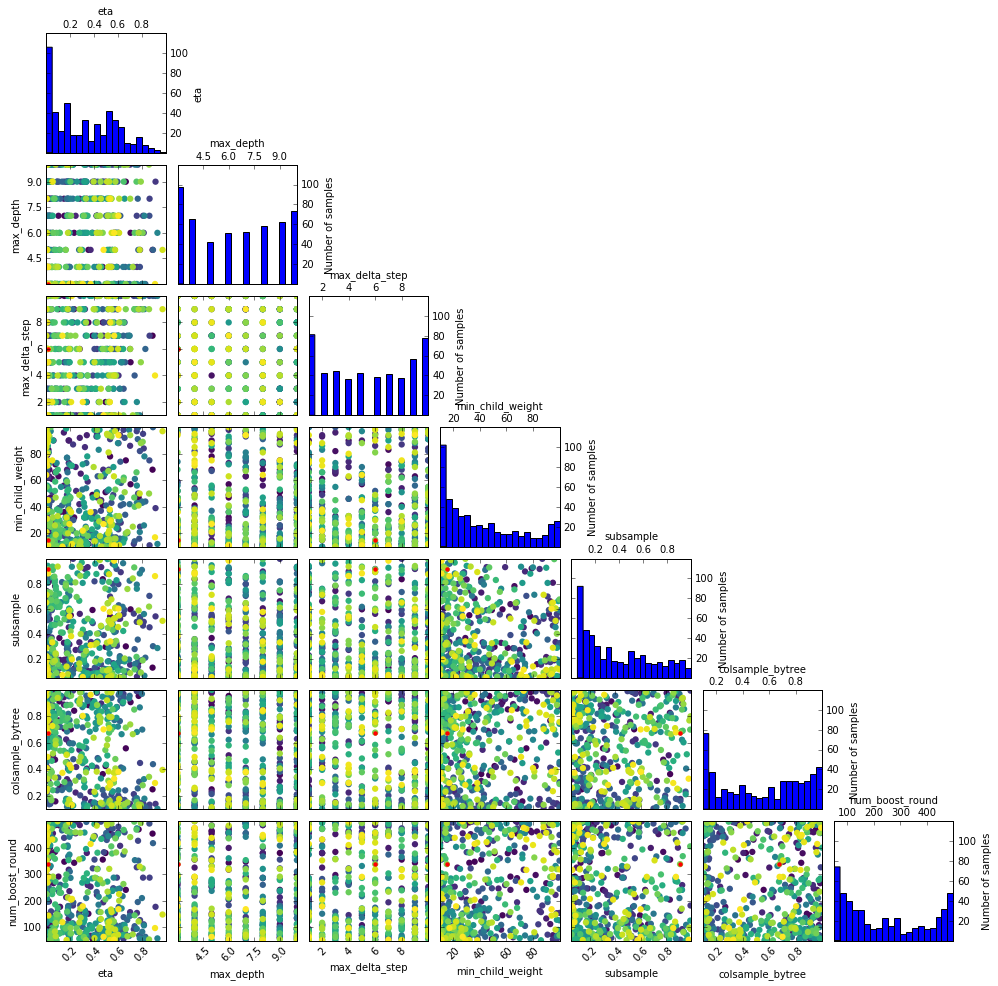

In [11]:
ax    = skopt.plots.plot_evaluations(res_forest)

# Add labels down the diagonal and across the bottom
for i, axis in enumerate(ax):
    axis[i].set_xlabel(param_order[i])
    axis[0].set_ylabel(param_order[i])

for i, axis in enumerate(ax[len(ax)-1]):
    axis.set_xlabel(param_order[i])

## GP-based optimization

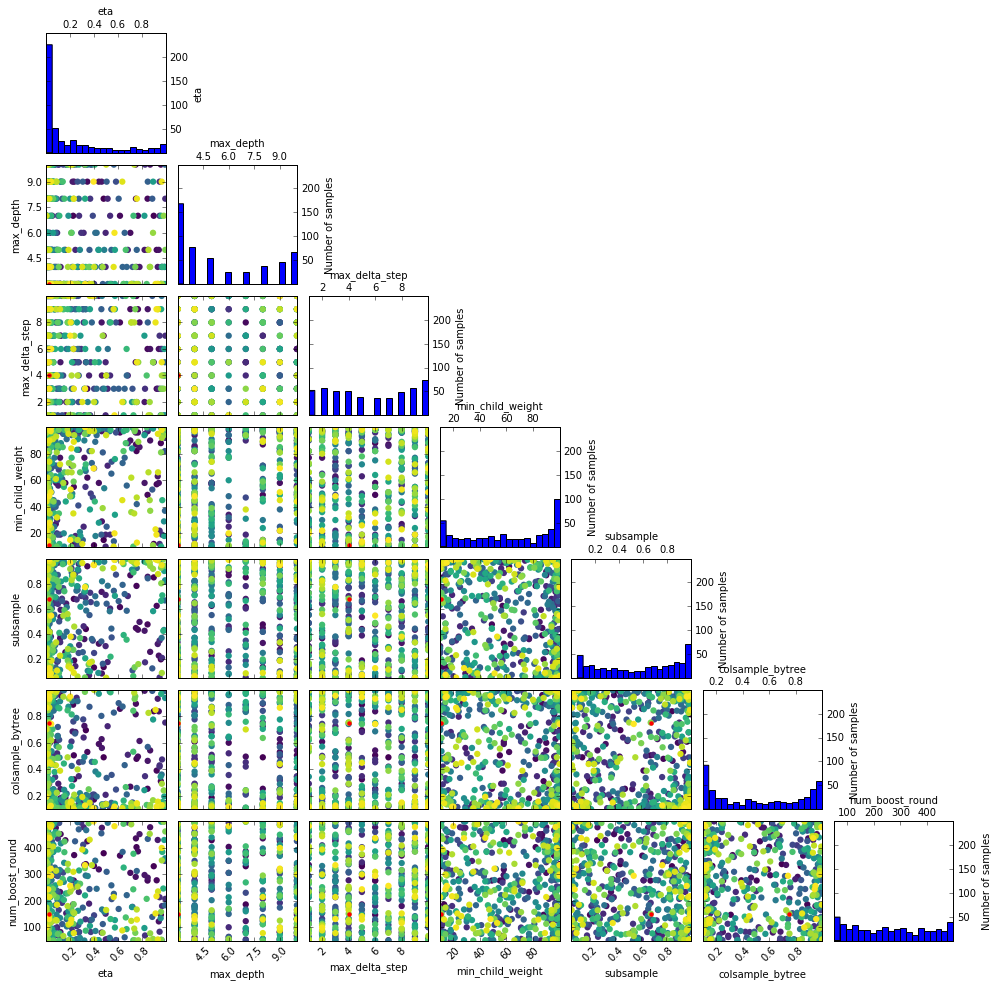

In [12]:
ax    = skopt.plots.plot_evaluations(res_gp)

# Add labels down the diagonal and across the bottom
for i, axis in enumerate(ax):
    axis[i].set_xlabel(param_order[i])
    axis[0].set_ylabel(param_order[i])

for i, axis in enumerate(ax[len(ax)-1]):
    axis.set_xlabel(param_order[i])

# Test the models

We now use the cross-validation set to test the 'best' models returned from scikit-optimize in each of the algorithms. 

In [13]:
# Prepare the training data:
dtrain = xgb.DMatrix(X, label = y, missing = float('NaN'))

## Forest-based optimization

In [14]:
parameters = list_to_dict(res_forest.x)
# Fit the model:
fitted_model = xgb.train(
                    parameters,
                    dtrain,
                    int(parameters['num_boost_round'])
                )

# Make predictions:
ypred = fitted_model.predict(xgb.DMatrix(Xtest, missing = float('NaN')))

# Performance metrics
print 'area under roc curve:', roc_auc_score(ycv, ypred)
print 'f1:', f1_score(ycv, ypred > .5)
print 'area under precision-recall curve:', average_precision_score(ycv, ypred)
print 'confusion matrix:'
print np.array(confusion_matrix(ycv, ypred > .5))

area under roc curve: 0.772100002007
f1: 0.462809917355
area under precision-recall curve: 0.584605238078
confusion matrix:
[[583  64]
 [196 112]]


## GP-based optimization

In [15]:
parameters = list_to_dict(res_gp.x)
# Fit the model:
fitted_model = xgb.train(
                    parameters,
                    dtrain,
                    int(parameters['num_boost_round'])
                )

# Make predictions:
ypred = fitted_model.predict(xgb.DMatrix(Xtest, missing = float('NaN')))

# Performance metrics
print 'area under roc curve:', roc_auc_score(ycv, ypred)
print 'f1:', f1_score(ycv, ypred > .5)
print 'area under precision-recall curve:', average_precision_score(ycv, ypred)
print 'confusion matrix:'
print np.array(confusion_matrix(ycv, ypred > .5))

area under roc curve: 0.771686003332
f1: 0.461215932914
area under precision-recall curve: 0.581643011957
confusion matrix:
[[588  59]
 [198 110]]
